In [11]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import LSTM
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline

In [2]:
datapath = 'S:\ebao\ABSA\Data\OpeNER\OpeNER_TOP.csv'

In [3]:
dataset = pd.read_csv(datapath)

In [4]:
dataset.shape

(4150, 3)

In [5]:
dataset.head()

,TARGET,OTE,POLARITY
0,Hotel,full of Russians and children,Negative
1,evening entertainment,Not suitable for couples without children,Negative
2,evening entertainment,almost nill,Negative
3,evening entertainment,geared for families,Negative
4,The bar staff,make nice comments,Positive


In [6]:
dataset['TOKENS'] = dataset.OTE.apply(lambda x: x.split())
dataset['TLEN'] = dataset.TOKENS.apply(lambda x: len(x))
dataset['CLASS'] = ~dataset.POLARITY.str.contains('Negative')

In [9]:
dataset.head(15)

,TARGET,OTE,POLARITY,TOKENS,TLEN,CLASS
0,Hotel,full of Russians and children,Negative,"[full, of, Russians, and, children]",5,False
1,evening entertainment,Not suitable for couples without children,Negative,"[Not, suitable, for, couples, without, children]",6,False
2,evening entertainment,almost nill,Negative,"[almost, nill]",2,False
3,evening entertainment,geared for families,Negative,"[geared, for, families]",3,False
4,The bar staff,make nice comments,Positive,"[make, nice, comments]",3,True
5,The bar staff,did make an effort to smile,Positive,"[did, make, an, effort, to, smile]",6,True
6,The bar staff,overworked,Negative,[overworked],1,False
7,The bar staff,tired,Negative,[tired],1,False
8,Room,large,Positive,[large],1,True
9,Room,very clean,StrongPositive,"[very, clean]",2,True


In [130]:
def freq_dist(tokens):
    c = Counter()
    for t in tokens:
        c.update(t)
    return c

def w_index(counter, start_idx=3):
    w_idx = {w:i+start_idx for i,(w,c) in enumerate(counter.most_common())}
    return w_idx


def df2feats(df, colname, w_idx):
    data = df[colname].apply(lambda x: [w_idx[w] for w in x]).values
    return data


def train_test(data, test_per=0.25):
    split = int(data.shape[0]*(1-0.25))
    
    if len(data.shape) > 1:
        train = data[:split,:]
        test = data[split:,:]
    else:
        train = data[:split]
        test = data[split:]
    
    return train,test
   
    

In [66]:
c = freq_dist(dataset.TOKENS)

In [67]:
c.most_common()[-10:]

[('entrance', 1),
 ('Nevskii', 1),
 ('elevators', 1),
 ('outdated', 1),
 ('joy', 1),
 ('packing', 1),
 ('pizza', 1),
 ('recommendations', 1),
 ('cheaper', 1),
 ('exhibition', 1)]

In [140]:
w_idx = w_index(c, start_idx=0)

In [141]:
data = df2feats(dataset, 'TOKENS', w_idx)
data

array([[146, 8, 880, 22, 236], [112, 1939, 16, 1573, 268, 236], [562, 938],
       ..., [706], [317, 215, 604], [393]], dtype=object)

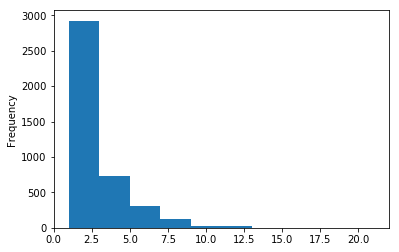

In [142]:
dataset.TLEN.plot('hist')

In [143]:
data = sequence.pad_sequences(data, maxlen=10).astype('float32')
print(data.shape)
data

(4150, 10)


array([[    0.,     0.,     0., ...,   880.,    22.,   236.],
       [    0.,     0.,     0., ...,  1573.,   268.,   236.],
       [    0.,     0.,     0., ...,     0.,   562.,   938.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,   706.],
       [    0.,     0.,     0., ...,   317.,   215.,   604.],
       [    0.,     0.,     0., ...,     0.,     0.,   393.]], dtype=float32)

In [144]:
labels = dataset.CLASS.values.astype('float32')
print(labels.shape)
labels

(4150,)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [145]:
X_train,X_test = train_test(data)
y_train,y_test = train_test(labels)

In [146]:
X_train.shape

(3112, 10)

In [147]:
y_train.shape

(3112,)

In [148]:
X_test.shape

(1038, 10)

In [135]:
y_test.shape

(1038,)

In [136]:
max(w_idx.values())

1966

In [137]:
model = Sequential()
model.add(Embedding(1966, 128, input_length=10))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [138]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [139]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=15,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 3112 samples, validate on 1038 samples
Epoch 1/15
2112/3112 [===================>..........] - ETA: 1s - loss: 0.5495 - acc: 0.7372  

InvalidArgumentError: indices[7,8] = 1966 is not in [0, 1966)
	 [[Node: embedding_4/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_4/embeddings/read, _recv_embedding_4_input_0)]]

Caused by op 'embedding_4/Gather', defined at:
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-137-8d67b504881d>", line 2, in <module>
    model.add(Embedding(1966, 128, input_length=10))
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\keras\models.py", line 422, in add
    layer(x)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\keras\layers\embeddings.py", line 119, in call
    out = K.gather(self.embeddings, inputs)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 966, in gather
    return tf.gather(reference, indices)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1359, in gather
    validate_indices=validate_indices, name=name)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[7,8] = 1966 is not in [0, 1966)
	 [[Node: embedding_4/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_4/embeddings/read, _recv_embedding_4_input_0)]]
